In [1]:
import tensorflow as tf
import numpy as np
import importlib.util
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def load_module(path):
    spec = importlib.util.spec_from_file_location("module.name", path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module

def load_arch(arch_path):
    arch = load_module(arch_path)
    nn = arch.CNN()

    g = tf.Graph()
    with g.as_default():
        nn.create_architecture()
    return g, nn

In [3]:
graph, nn = load_arch("arch_invariant.py")

In [4]:
sess = tf.Session(graph=graph)

In [5]:
sess.run(tf.variables_initializer(graph.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)))

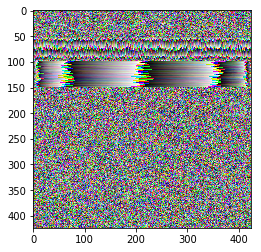

In [6]:
x = np.random.normal(size=(424, 424, 3))
x[50:100, :, :]  = np.sort(x[50:100, :, :], 0)
x[100:150, :, :] = np.sort(x[100:150, :, :], 1)
x[150:200, :, :] = np.sort(x[150:200, :, :], 2)
plt.imshow(x)

In [7]:
def dihedral(x, i):
    x = x.copy()
    if i & 4:
        x = np.transpose(x, (1, 0, 2))  # tau[4]
    if i & 1:
        x = x[:, ::-1, :]  # tau[1]
    if i & 2:
        x = x[::-1, :, :]  # tau[2]
    return x

In [8]:
xs = np.array([dihedral(x, i) for i in range(8)])

In [9]:
ps = sess.run(nn.tfp, feed_dict={nn.tfx: xs})
print(np.transpose(ps))

[[  7.66487181e-01   7.66488612e-01   7.66487956e-01   7.66488314e-01
    7.66488194e-01   7.66488016e-01   7.66486883e-01   7.66486764e-01]
 [  1.93579700e-02   1.93578564e-02   1.93579104e-02   1.93578489e-02
    1.93577819e-02   1.93579011e-02   1.93578787e-02   1.93579495e-02]
 [  2.14154869e-01   2.14153528e-01   2.14154154e-01   2.14153886e-01
    2.14153960e-01   2.14154124e-01   2.14155242e-01   2.14155272e-01]
 [  4.84145852e-03   4.84142220e-03   4.84138681e-03   4.84138727e-03
    4.84143011e-03   4.84139984e-03   4.84144036e-03   4.84144827e-03]
 [  1.45165101e-02   1.45164328e-02   1.45165231e-02   1.45164607e-02
    1.45163517e-02   1.45164998e-02   1.45164384e-02   1.45165008e-02]
 [  7.21412012e-04   7.21408986e-04   7.21407298e-04   7.21403572e-04
    7.21392105e-04   7.21411314e-04   7.21403921e-04   7.21399498e-04]
 [  1.37950974e-02   1.37950238e-02   1.37951169e-02   1.37950573e-02
    1.37949595e-02   1.37950871e-02   1.37950340e-02   1.37951011e-02]
 [  9.7956629

In [10]:
test = sess.run(nn.test, feed_dict={nn.tfx: xs})
test = np.reshape(test, (8, 8, -1))

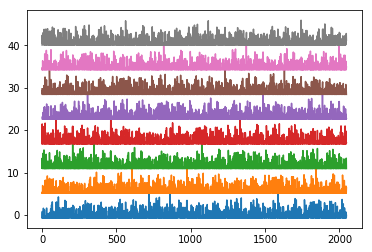

In [11]:
step = test[0].max() - test[0].min()
for i in range(8):
    plt.plot(test[i].flatten() + step * i)

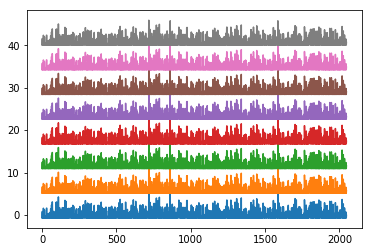

In [12]:
mt = np.array([ [0, 1, 2, 3, 4, 5, 6, 7], [1, 0, 3, 2, 5, 4, 7, 6],
                [2, 3, 0, 1, 6, 7, 4, 5], [3, 2, 1, 0, 7, 6, 5, 4],
                [4, 6, 5, 7, 0, 2, 1, 3], [5, 7, 4, 6, 1, 3, 0, 2],
                [6, 4, 7, 5, 2, 0, 3, 1], [7, 5, 6, 4, 3, 1, 2, 0]])
# tau[mt[a,b]] = tau[a] o tau[b]

iv = np.array([0, 1, 2, 3, 4, 6, 5, 7])
# tau[iv[a]] is the inverse of tau[a]

for i in range(8):
    plt.plot(test[i][mt[i]].flatten() + step * i)